In [1]:
import os
import pandas as pd
from pathlib import Path
import re
import torch
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import torchvision.models as models
from torchsummary import summary
from architectures.SimpleCNN import SimpleCNN
from architectures.DenseNetAdjusted import DenseNet

In [2]:
# RAVDESS

path = 'datasets/archive/audio_speech_actors_01-24'

train_data = []
test_data = []

# Speaker split (gender-balanced)
train_speakers = ["01", "03", "05", "07", "09", "11", "13", "15", "17", "19", "02", "04", "06", "08", "10", "12", "14", "16", "18", "20"]
test_speakers = ["21", "23", "22", "24"]

emotion_map = {
    "01": "neutral",
    # "02": "calm",  -> remove not in crema-d
    "03": "happy",
    "04": "sad",
    "05": "angry",
    "06": "fearful",
    "07": "disgust",
    # "08": "surprised" -> remove not in crema-d
}

for folder in sorted(os.listdir(path)):
    folder_path = os.path.join(path, folder)
    for file in os.listdir(folder_path):
        match = re.match(r"(\d+)-(\d+)-(\d+)-(\d+)-(\d+)-(\d+)-(\d+)\.wav", file)
        if match:
            filepath = str(Path(path) / folder / file)
            indicators = match.groups()
            emotion_code = indicators[2]
            actor_id = indicators[-1]
            gender = 'Female' if int(indicators[-1]) % 2 == 0 else 'Male'
            if emotion_code not in emotion_map:
                continue

            record = {
                "path": filepath,
                "emotion": emotion_map[emotion_code],
                "gender": gender,
                "source": "RAVDESS"
            }

            if actor_id in train_speakers:
                train_data.append(record)
            else:
                test_data.append(record)

train_df = pd.DataFrame(train_data)
test_df = pd.DataFrame(test_data)

train_df.to_csv("train_split.csv", index=False)
test_df.to_csv("test_split.csv", index=False)

In [3]:
demo_df = pd.read_csv('datasets/CREMA-D/VideoDemographics.csv')
print(demo_df.head(10))
print(demo_df.columns)

   ActorID  Age     Sex              Race     Ethnicity
0     1001   51    Male         Caucasian  Not Hispanic
1     1002   21  Female         Caucasian  Not Hispanic
2     1003   21  Female         Caucasian  Not Hispanic
3     1004   42  Female         Caucasian  Not Hispanic
4     1005   29    Male  African American  Not Hispanic
5     1006   58  Female         Caucasian  Not Hispanic
6     1007   38  Female  African American  Not Hispanic
7     1008   46  Female         Caucasian  Not Hispanic
8     1009   24  Female         Caucasian  Not Hispanic
9     1010   27  Female         Caucasian  Not Hispanic
Index(['ActorID', 'Age', 'Sex', 'Race', 'Ethnicity'], dtype='object')


In [4]:
# CREMA-D

path = 'datasets/CREMA-D/AudioWAV'

# Load demographics for gender mapping
demo_df = pd.read_csv('datasets/CREMA-D/VideoDemographics.csv')
gender_map = dict(zip(demo_df['ActorID'], demo_df['Sex']))

# Check how many actors
print(f"Total actors: {len(gender_map)}")
print(f"Males: {list(gender_map.values()).count('Male')}")
print(f"Females: {list(gender_map.values()).count('Female')}")

Total actors: 91
Males: 48
Females: 43


In [5]:
train_data = []
test_data = []

emotion_map = {
    "ANG": "angry",
    "DIS": "disgust",
    "FEA": "fearful",
    "HAP": "happy",
    "NEU": "neutral",
    "SAD": "sad"
}

# Get all actor IDs and split by gender
all_actors = demo_df['ActorID'].tolist()
male_actors = demo_df[demo_df['Sex'] == 'Male']['ActorID'].tolist()
female_actors = demo_df[demo_df['Sex'] == 'Female']['ActorID'].tolist()

# 80/20 split per gender
train_males = male_actors[:38]      # 38 males for train
test_males = male_actors[38:]       # 10 males for test

train_females = female_actors[:34]  # 34 females for train  
test_females = female_actors[34:]   # 9 females for test

train_speakers = train_males + train_females  # 72 speakers
test_speakers = test_males + test_females      # 19 speakers

print(f"\nTrain speakers: {len(train_speakers)} ({len(train_males)}M, {len(train_females)}F)")
print(f"Test speakers: {len(test_speakers)} ({len(test_males)}M, {len(test_females)}F)")

# Parse audio files
for file in os.listdir(path):
    if not file.endswith('.wav'):
        continue
        
    # Filename: 1001_IEO_ANG_HI.wav
    parts = file.replace('.wav', '').split('_')
    
    if len(parts) < 4:
        continue
    
    actor_id = int(parts[0])
    emotion_code = parts[2]
    
    if emotion_code not in emotion_map:
        continue
    
    filepath = str(Path(path) / file)
    gender = gender_map.get(actor_id, 'Unknown')
    
    record = {
        "path": filepath,
        "emotion": emotion_map[emotion_code],
        "gender": gender,
        "source": "CREMA-D"
    }
    
    if actor_id in train_speakers:
        train_data.append(record)
    elif actor_id in test_speakers:
        test_data.append(record)

# Create DataFrames
train_df_cremad = pd.DataFrame(train_data)
test_df_cremad = pd.DataFrame(test_data)

# Verify
print("\nCREMA-D TRAIN:")
print(f"  Samples: {len(train_df_cremad)}")
print(f"  By gender: {train_df_cremad['gender'].value_counts().to_dict()}")

print("\nCREMA-D TEST:")
print(f"  Samples: {len(test_df_cremad)}")
print(f"  By gender: {test_df_cremad['gender'].value_counts().to_dict()}")


Train speakers: 72 (38M, 34F)
Test speakers: 19 (10M, 9F)

CREMA-D TRAIN:
  Samples: 5885
  By gender: {'Male': 3110, 'Female': 2775}

CREMA-D TEST:
  Samples: 1557
  By gender: {'Male': 820, 'Female': 737}


In [6]:
# Combine with RAVDESS
train_df = pd.read_csv("train_split.csv")
test_df = pd.read_csv("test_split.csv")

train_df = pd.concat([train_df, train_df_cremad], ignore_index=True)
test_df = pd.concat([test_df, test_df_cremad], ignore_index=True)

train_df.to_csv("train_split.csv", index=False)
test_df.to_csv("test_split.csv", index=False)

print(f"\nFINAL TRAIN: {len(train_df)}")
print(f"FINAL TEST: {len(test_df)}")


FINAL TRAIN: 6765
FINAL TEST: 1733


In [7]:
# quick check to ensure "calm" emotion is removed
print(train_df['emotion'].unique())

['neutral' 'happy' 'sad' 'angry' 'fearful' 'disgust']


In [8]:
sample_path = train_df.iloc[0]['path']
sample_emotion = train_df.iloc[0]['emotion']
print (f"Sample path: {sample_path},\nemotion: {sample_emotion}")

Sample path: datasets\archive\audio_speech_actors_01-24\Actor_01\03-01-01-01-01-01-01.wav,
emotion: neutral


In [9]:

sample_rate_1 = 16000
sample_rate_2 = 22050
duration_1 = 3
duration_2 = 5


waveform_1, sr_1 = librosa.load(sample_path, sr=sample_rate_1)
print(f"\nOriginal_1:")
print(f"  Sample rate: {sr_1} Hz")
print(f"  Shape: {waveform_1.shape}")
print(f"  Duration: {len(waveform_1)/sr_1:.2f} seconds")

waveform_2, sr_2 = librosa.load(sample_path, sr=sample_rate_2)
print(f"\nOriginal_2:")
print(f"  Sample rate: {sr_2} Hz")
print(f"  Shape: {waveform_2.shape}")
print(f"  Duration: {len(waveform_2)/sr_2:.2f} seconds")


Original_1:
  Sample rate: 16000 Hz
  Shape: (52853,)
  Duration: 3.30 seconds

Original_2:
  Sample rate: 22050 Hz
  Shape: (72838,)
  Duration: 3.30 seconds


In [10]:
target_length_1 = sample_rate_1 * duration_1  # 3 seconds at 16kHz
target_length_2 = sample_rate_2 * duration_2  # 5 seconds at 22.05kHz

waveform_1 = librosa.util.fix_length(waveform_1, size=target_length_1)
waveform_2 = librosa.util.fix_length(waveform_2, size=target_length_2)

print(f"Final waveform_1 shape: {waveform_1.shape}")
print(f"Final waveform_2 shape: {waveform_2.shape}")

Final waveform_1 shape: (48000,)
Final waveform_2 shape: (110250,)


In [11]:
mel_spec_1 = librosa.feature.melspectrogram(
    y=waveform_1,
    sr=sample_rate_1,
    n_mels = 128,
    n_fft=2048,
    hop_length=512
)
print(f"\nMel-spectrogram shape: {mel_spec_1.shape}")

mel_spec_2 = librosa.feature.melspectrogram(
    y=waveform_2,
    sr=sample_rate_2,
    n_mels = 128,
    n_fft=2048,
    hop_length=512
)
print(f"\nMel-spectrogram shape: {mel_spec_2.shape}")


Mel-spectrogram shape: (128, 94)

Mel-spectrogram shape: (128, 216)


In [12]:
mel_spec_db_1 = librosa.power_to_db(mel_spec_1, ref=np.max)
print(f"Mel-spectrogram (dB) shape: {mel_spec_db_1.shape}")
mel_spec_db_2 = librosa.power_to_db(mel_spec_2, ref=np.max)
print(f"Mel-spectrogram (dB) shape: {mel_spec_db_2.shape}")

Mel-spectrogram (dB) shape: (128, 94)
Mel-spectrogram (dB) shape: (128, 216)


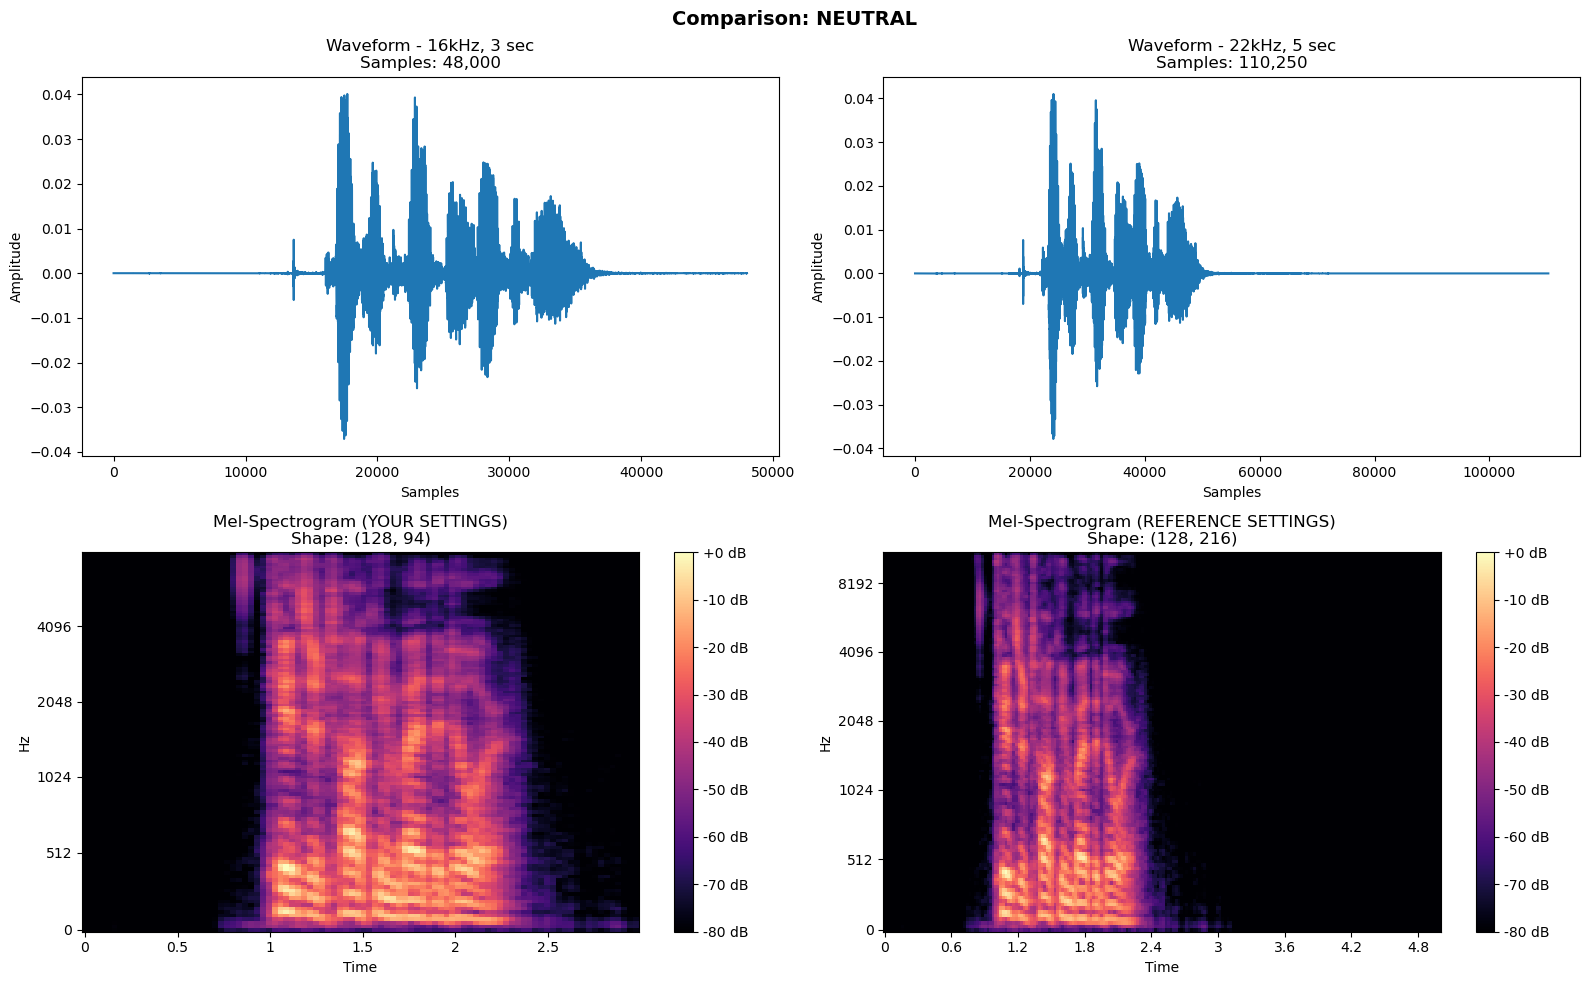


COMPARISON SUMMARY

Setting                   Yours                Reference           
------------------------------------------------------------
Sample Rate               16,000 Hz           22,050 Hz
Duration                  3 sec                5 sec
Total Samples             48,000              110,250
Spectrogram Shape         (128, 94)            (128, 216)
Time Frames               94                  216
------------------------------------------------------------

Reference has 2.3x more temporal information!


In [13]:
# ============== PLOT COMPARISON ==============
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# Row 1: Waveforms
axes[0, 0].plot(waveform_1)
axes[0, 0].set_title(f'Waveform - 16kHz, 3 sec\nSamples: {len(waveform_1):,}')
axes[0, 0].set_xlabel('Samples')
axes[0, 0].set_ylabel('Amplitude')

axes[0, 1].plot(waveform_2)
axes[0, 1].set_title(f'Waveform - 22kHz, 5 sec\nSamples: {len(waveform_2):,}')
axes[0, 1].set_xlabel('Samples')
axes[0, 1].set_ylabel('Amplitude')

# Row 2: Mel-Spectrograms (dB)
img1 = librosa.display.specshow(
    mel_spec_db_1, x_axis='time', y_axis='mel', sr=sample_rate_1, ax=axes[1, 0]
)
axes[1, 0].set_title(f'Mel-Spectrogram (YOUR SETTINGS)\nShape: {mel_spec_db_1.shape}')
fig.colorbar(img1, ax=axes[1, 0], format='%+2.0f dB')

img2 = librosa.display.specshow(
    mel_spec_db_2, x_axis='time', y_axis='mel', sr=sample_rate_2, ax=axes[1, 1]
)
axes[1, 1].set_title(f'Mel-Spectrogram (REFERENCE SETTINGS)\nShape: {mel_spec_db_2.shape}')
fig.colorbar(img2, ax=axes[1, 1], format='%+2.0f dB')

plt.suptitle(f'Comparison: {sample_emotion.upper()}', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('audio_comparison.png', dpi=150)
plt.show()

# ============== SUMMARY ==============
print("\n" + "=" * 60)
print("COMPARISON SUMMARY")
print("=" * 60)
print(f"\n{'Setting':<25} {'Yours':<20} {'Reference':<20}")
print("-" * 60)
print(f"{'Sample Rate':<25} {sample_rate_1:,} Hz{'':<10} {sample_rate_2:,} Hz")
print(f"{'Duration':<25} {duration_1} sec{'':<15} {duration_2} sec")
print(f"{'Total Samples':<25} {len(waveform_1):,}{'':<13} {len(waveform_2):,}")
print(f"{'Spectrogram Shape':<25} {mel_spec_db_1.shape}{'':<11} {mel_spec_db_2.shape}")
print(f"{'Time Frames':<25} {mel_spec_db_1.shape[1]}{'':<17} {mel_spec_db_2.shape[1]}")
print("-" * 60)
print(f"\nReference has {mel_spec_db_2.shape[1] / mel_spec_db_1.shape[1]:.1f}x more temporal information!")

128 mel bands - frequency range leading up to 48000hz (3 sec time)

94 time windows

hence the shape (128, 94)

notice the power db graph (scale adjusted for human audible samples) - we set the loudest volume (highest amplitude) to 0, closest to that will be loude voice represented with bright colors and then leading away from it is quiter around -80 db

In [ ]:
def extract_time_features(waveform, sr):
    # Zero Crossing Rate
    zcr = librosa.feature.zero_crossing_rate(
        waveform, frame_length=2048, hop_length=512
    )
    
    # RMS Energy
    energy = librosa.feature.rms(
        y=waveform, frame_length=2048, hop_length=512
    )
    
    # MFCCs
    mfccs = librosa.feature.mfcc(
        y=waveform, sr=sr, n_fft=2048, hop_length=512, n_mfcc=13
    )
    
    return zcr, energy, mfccs

In [14]:
class EmotionDataset(Dataset):
    def __init__(self, csv_path, augment=False):
        self.df = pd.read_csv(csv_path)
        self.augment = augment
        
        # Emotion to number mapping
        self.emotion_to_idx = {
            'angry': 0,
            'disgust': 1,
            'fearful': 2,
            'happy': 3,
            'neutral': 4,
            'sad': 5
        }
        
        # Audio settings (UPDATED to match reference)
        self.sample_rate = 22050    # Changed from 16000
        self.duration = 5           # Changed from 3
        self.target_length = self.sample_rate * self.duration  # 110250
        
        # Mel-spectrogram settings
        self.n_mels = 128
        self.n_fft = 2048
        self.hop_length = 512
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        
        # 1. Load audio
        waveform, sr = librosa.load(row['path'], sr=self.sample_rate, mono=True)
        
        # 2. Fix length to exactly 5 seconds (110250 samples at 22.05kHz)
        if len(waveform) < self.target_length:
            padding = self.target_length - len(waveform)
            offset = padding // 2
            waveform = np.pad(waveform, (offset, padding - offset), 'constant')
        else:
            waveform = waveform[:self.target_length]

        # 3. Augmentation (only if enabled)
        if self.augment:
            # Time shift
            shift = np.random.randint(-self.sample_rate, self.sample_rate)  # Increased for longer audio
            waveform = np.roll(waveform, shift)
            
            # Add noise
            noise = np.random.normal(0, 0.005, waveform.shape)
            waveform = waveform + noise
        
        # 4. Convert to mel-spectrogram
        mel_spec = librosa.feature.melspectrogram(
            y=waveform,
            sr=self.sample_rate,
            n_mels=self.n_mels,
            n_fft=self.n_fft,
            hop_length=self.hop_length
        )
        
        # 5. Convert to dB scale
        mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
        
        # 6. Normalize to 0-1 range
        mel_spec_db = (mel_spec_db - mel_spec_db.min()) / (mel_spec_db.max() - mel_spec_db.min() + 1e-8)
        
        # 7. Convert to tensor and add channel dimension
        mel_spec_tensor = torch.FloatTensor(mel_spec_db).unsqueeze(0)  # Shape: (1, 128, 216)
        
        # 8. Get label
        label = self.emotion_to_idx[row['emotion']]
        
        return mel_spec_tensor, label

In [15]:
class EarlyStopping:
    def __init__(self, patience=10, min_delta=0.001):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
        
    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0
        
        return self.early_stop

# Testing starts here

In [16]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"using device: {device}")

using device: cuda


In [17]:
# Datasets
train_dataset = EmotionDataset('train_split.csv')
test_dataset = EmotionDataset('test_split.csv')

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [18]:
print(f"Train: {len(train_dataset)} samples")
print(f"Test: {len(test_dataset)} samples")

Train: 6765 samples
Test: 1733 samples


In [19]:
df = pd.read_csv('train_split.csv')
print(df["emotion"].value_counts())

emotion
happy      1165
sad        1165
fearful    1165
angry      1165
disgust    1165
neutral     940
Name: count, dtype: int64


In [20]:
# # Model
# # model = EmotionResNet().to(device)
# model = DenseNet(n_blocks=[2, 4, 8, 4], in_channels=1, num_classes=6, growth_rate=16, reduction=0.5, filters=32, kernel_size=3).to(device)
# summary(model, input_size=(1, 128, 94))  # Adjust input size based on your mel-spectrogram dimensions

# # Loss and optimizer
# criterion = nn.CrossEntropyLoss()
# optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-4)

In [21]:
def train_model(model, train_loader, test_loader, epochs=50, lr=0.001, patience=10, device='cuda', weight_decay=1e-4):
    
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.1, patience=3, verbose=True
    )
    early_stopping = EarlyStopping(patience=patience)
    
    best_acc = 0.0
    best_model_state = None
    history = {'train_acc': [], 'test_acc': [], 'train_loss': [], 'test_loss': []}
    
    for epoch in range(epochs):
        
        # Training
        model.train()
        train_loss = 0
        train_correct = 0
        train_total = 0
        
        for mel_specs, labels in train_loader:
            mel_specs = mel_specs.to(device)
            labels = labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(mel_specs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()
        
        train_acc = 100 * train_correct / train_total
        train_loss = train_loss / len(train_loader)
        
        # Testing
        model.eval()
        test_loss = 0
        test_correct = 0
        test_total = 0
        
        with torch.no_grad():
            for mel_specs, labels in test_loader:
                mel_specs = mel_specs.to(device)
                labels = labels.to(device)
                
                outputs = model(mel_specs)
                loss = criterion(outputs, labels)
                
                test_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                test_total += labels.size(0)
                test_correct += (predicted == labels).sum().item()
        
        test_acc = 100 * test_correct / test_total
        test_loss = test_loss / len(test_loader)
        scheduler.step(test_loss)
        
        # Save history
        history['train_acc'].append(train_acc)
        history['test_acc'].append(test_acc)
        history['train_loss'].append(train_loss)
        history['test_loss'].append(test_loss)

        print(f"Epoch {epoch+1}/{epochs} | Train Acc: {train_acc:.2f}% | Test Acc: {test_acc:.2f}% | Train Loss: {train_loss:.4f} | Test Loss: {test_loss:.4f}")
        
        # Save best model
        if test_acc > best_acc:
            best_acc = test_acc
            best_model_state = model.state_dict().copy()
        
        # Early stopping check
        if early_stopping(test_loss):
            print(f"  Early stopping at epoch {epoch+1}")
            break
    
    # Restore best model
    if best_model_state:
        model.load_state_dict(best_model_state)
    
    return best_acc, history


def hyperparameter_search(train_loader, test_loader, device='cuda'):
    
    # Hyperparameters
    kernel_sizes = [5, 7]
    filter_counts = [64, 128]
    
    results = []
    all_histories = []
    
    print("=" * 60)
    print("HYPERPARAMETER SEARCH")
    print("=" * 60)
    
    for kernel_size in kernel_sizes:
        for num_filters in filter_counts:
            
            print(f"\nKernel: {kernel_size}x{kernel_size} | Filters: {num_filters}")
            print("-" * 40)
            
            # Create model
            # model = DenseNet(
            #     n_blocks=[2, 2, 2, 2],
            #     in_channels=1,
            #     num_classes=6,
            #     growth_rate=8,
            #     reduction=0.5,
            #     filters=num_filters,
            #     kernel_size=kernel_size
            # ).to(device)

            model = SimpleCNN(num_filters=num_filters, kernel_size=kernel_size, num_classes=6).to(device)
            
            # model summary
            stats = summary(model, input_size=(1, 128, 216))
            
            # Train
            best_acc, history = train_model(
                model=model,
                train_loader=train_loader,
                test_loader=test_loader,
                epochs=50,
                lr=0.001,
                patience=10,
                device=device,
                weight_decay=0
            )
            
            print(f"Best Accuracy: {best_acc:.2f}%")
            
            # Store results
            results.append({
                'kernel_size': kernel_size,
                'num_filters': num_filters,
                'best_acc': best_acc,
                'params': stats.total_params
            })
            all_histories.append(history)
    
    return results, all_histories

In [ ]:
results, histories = hyperparameter_search(train_loader, test_loader, device)

HYPERPARAMETER SEARCH

Kernel: 5x5 | Filters: 64
----------------------------------------
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 216]           1,664
       BatchNorm2d-2         [-1, 64, 128, 216]             128
              ReLU-3         [-1, 64, 128, 216]               0
         MaxPool2d-4          [-1, 64, 64, 108]               0
            Conv2d-5         [-1, 128, 64, 108]         204,928
       BatchNorm2d-6         [-1, 128, 64, 108]             256
              ReLU-7         [-1, 128, 64, 108]               0
         MaxPool2d-8          [-1, 128, 32, 54]               0
            Conv2d-9          [-1, 128, 32, 54]         409,728
      BatchNorm2d-10          [-1, 128, 32, 54]             256
             ReLU-11          [-1, 128, 32, 54]               0
AdaptiveAvgPool2d-12            [-1, 128, 1, 1]               0
          Fla

m:\anaconda\envs\alex\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/50 | Train Acc: 32.28% | Test Acc: 17.20% | Train Loss: 1.6055 | Test Loss: 5.2369
Epoch 2/50 | Train Acc: 36.95% | Test Acc: 22.62% | Train Loss: 1.5187 | Test Loss: 1.9580
Epoch 3/50 | Train Acc: 40.65% | Test Acc: 23.31% | Train Loss: 1.4639 | Test Loss: 2.2683
Epoch 4/50 | Train Acc: 42.14% | Test Acc: 36.64% | Train Loss: 1.4331 | Test Loss: 1.5248
Epoch 5/50 | Train Acc: 43.30% | Test Acc: 36.53% | Train Loss: 1.3975 | Test Loss: 1.5125
Epoch 6/50 | Train Acc: 43.70% | Test Acc: 38.32% | Train Loss: 1.3925 | Test Loss: 1.5114
Epoch 7/50 | Train Acc: 46.24% | Test Acc: 22.16% | Train Loss: 1.3601 | Test Loss: 2.8500
Epoch 8/50 | Train Acc: 47.15% | Test Acc: 33.18% | Train Loss: 1.3333 | Test Loss: 1.9674
Epoch 9/50 | Train Acc: 47.94% | Test Acc: 42.70% | Train Loss: 1.3045 | Test Loss: 1.4780
Epoch 10/50 | Train Acc: 49.28% | Test Acc: 28.51% | Train Loss: 1.2921 | Test Loss: 2.2981
Epoch 11/50 | Train Acc: 50.26% | Test Acc: 34.45% | Train Loss: 1.2669 | Test Loss: 1.80